# Q2
## 2.1

We have the 1D HMM:

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; \theta x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

We know the exact marginal likelihood $Z_* = p(y_{1:T})$ is given by

$$
p(y_{1:T}) = \int p(x_{0:T}, y_{1:T}) dx_{0:T}
$$

$$
= \int \pi_0(x_0) \prod_{t=1}^T \bigg(\tau(x_t | x_{t-1}) g(y_t | x_t) \bigg) dx_{0:T}
$$

We also note that equivalently

$$
p(y_{1:T}) = \prod_{t=1}^T p(y_t \mid y_{1:t-1})
$$

Where

$$
p(y_t \mid y_{1:t-1}) = \int p(y_t \mid x_t) p(x_t \mid y_{1:t-1}) \, dx_t
$$

Since we have a fully Gaussian HMM setup, we can use Kalman filter to compute 
$p(x_t \mid y_{1:t-1}) =  \mathcal{N}(x_t; \hat{m}_t, \hat{P}_t)$, where

\begin{align*}
\hat{m}_t &= \theta m_{t-1} \\
\hat{P}_t &= \theta P_{t-1} \theta^\top + Q
\end{align*}

So that we have 

$$
p(y_t \mid y_{1:t-1}) = \int \mathcal{N}(y_t; H x_t, R) \cdot \mathcal{N}(x_t; \hat{m}_t, \hat{P}_t) \, dx_t
$$

By Lemma 3.2, this is

$$
p(y_t \mid y_{1:t-1}) = \mathcal{N}(H \hat{m}_t , H^2 \hat{P}_t + R) = \mathcal{N}(H \hat{m}_t , S_t)
$$

Where we let $S_t = H^2 \hat{P}_t + R$ for simplicity


The full algorithm for computing $\log p(y_{1:T}) = \sum_{t=1}^T \log p(y_t \mid y_{1:t-1})$ is given by

- Input:
Starting point $ m_0, P_0$, and the sequence of observations $ y_{1:T} $ for the specific T.

    Set $\hat{m}_0 = m_0, \hat{P}_0 = P_0$

- Filtering:  
**For** $ n = 1, \dots, T $ **do**
    - Prediction step:
    \begin{align*}
    \hat{m}_t &= \theta m_{t-1} \\
    \hat{P}_t &= \theta P_{t-1} \theta^\top + Q
    \end{align*}

    - Update step:
    \begin{align*}
    S_t &= H \hat{P}_t H^\top + R \\
    K_t &= \hat{P}_t H^\top (S_t)^{-1} \\
    m_t &= \hat{m}_t + K_t (y_t - H \hat{m}_t) \\
    P_t &= (I - K_t H) \hat{P}_t
    \end{align*}

    **End for**    

- Return $ \hat{m}_{1:T}, S_{1:T}$

And we output
$$
\log p(y_{1:T}) = \sum_{t=1}^T \log \mathcal{N}(y_t; H \hat{m}_{t}, S_t)
$$



## 2.2

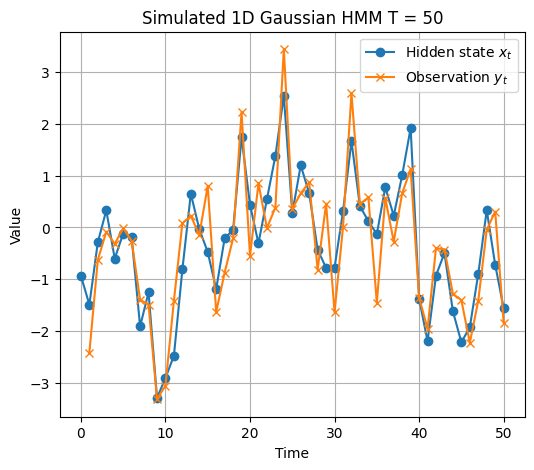

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
theta = 0.7
Q = 1.0
R = 0.5
P0 = 1.0
m0 = 0.0
H = 1.0
T = 50

# Initialize arrays
def simulate_hmm_q2(theta, Q, R, P0, m0, H, T):
    x = np.zeros(T + 1)  # state: x_0 to x_T
    y = np.zeros(T)      # observations: y_1 to y_T

    # Initial state
    x[0] = np.random.normal(m0, np.sqrt(P0))

    # Simulate the HMM
    for t in range(1, T + 1):
        x[t] = np.random.normal(theta * x[t - 1], np.sqrt(Q))         # state evolution
        y[t - 1] = np.random.normal(H * x[t], np.sqrt(R))             # observation

    return x, y

### sanity check
x,y = simulate_hmm_q2(theta, Q, R, P0, m0, H, T)

# Plot results
plt.figure(figsize=(6, 5))
plt.plot(range(T + 1), x, label='Hidden state $x_t$', marker='o')
plt.plot(range(1, T + 1), y, label='Observation $y_t$', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated 1D Gaussian HMM T = 50')
plt.grid(True)
plt.show()


In [5]:
T_range = [10, 20, 50, 100, 200, 500, 1000]
q2_data = {}
for t in T_range:
    x, y = simulate_hmm_q2(theta, Q, R, P0, m0, H, t)
    q2_data[t] = (x, y)

In [8]:
def kalman_filter_loglik(y, theta, Q, R, H, m0, P0):
    """
    Computes log p(y_{1:T}) = sum_t log N(y_t; H m_hat_t, S_t)
    """
    T = len(y)
    
    # Initialize
    m_hat = m0
    P_hat = P0
    
    m_filtered = np.zeros(T)
    S = np.zeros(T)
    loglik = 0.0
    
    for t in range(T):
        # Prediction step
        m_hat = theta * m_hat
        P_hat = theta * P_hat * theta + Q
        
        # Update step
        S_t = H * P_hat * H + R
        K_t = P_hat * H / S_t
        m_t = m_hat + K_t * (y[t] - H * m_hat)
        P_t = (1 - K_t * H) * P_hat
        
        # Store results
        m_filtered[t] = m_hat
        S[t] = S_t
        
        # Increment log-likelihood
        loglik += -0.5 * (np.log(2 * np.pi * S_t) + ((y[t] - H * m_hat) ** 2) / S_t)
        
        # Prepare for next iteration
        m_hat = m_t
        P_hat = P_t

    return m_filtered, S, loglik


In [10]:
loglik_dict = {}
for t, (x, y) in q2_data.items():
    m_filtered, S, log_py = kalman_filter_loglik(y, theta, Q, R, H, m0, P0)
    loglik_dict[t] = log_py
    print(f"T = {t}, log p(y_{1}:{t}) = {log_py:.2f}")

T = 10, log p(y_1:10) = -22.24
T = 20, log p(y_1:20) = -31.08
T = 50, log p(y_1:50) = -84.12
T = 100, log p(y_1:100) = -158.33
T = 200, log p(y_1:200) = -338.52
T = 500, log p(y_1:500) = -847.69
T = 1000, log p(y_1:1000) = -1682.57


## 2.3

Recall setup:

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; \theta x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

With a slight abuse of notations, we denote $\theta$ as the full parameters 
$m_0, P_0, \theta, Q, H, R$ which parametrize all three distributions $\pi_{\theta}, \tau_{\theta}, g_{\theta}$

To estimate $p_{\theta}(y_{1:T})$, we want to find the $\theta$ 
which maximizes likelihood $ \log p_{\theta}(y_{1:T})$.   
To do this, we perform gradient descent on $ -\log p_{\theta}(y_{1:T})$, and quote that 

$$
\nabla \log p_{\theta}(y_{1:T}) = \int \nabla \log p_{\theta}(x_{0:T}, y_{1:T}) \cdot p_{\theta}(x_{0:T}| y_{1:T}) dx_{0:T}
$$

We can estimate this gradient using monte carlo, by sampling $ x_{0:T}^{(i)} \sim  p_{\theta}(x_{0:T}| y_{1:T})  $, 
and obtain

\begin{align*}
\nabla \log p_{\theta}(y_{1:T}) &\approx \frac{1}{N} \sum_{i=1}^N  \nabla \log p_{\theta}(x_{0:T}^{(i)}, y_{1:T})
\end{align*}

We denote the MC estimator as $\alpha_k = \frac{1}{N} \sum_{i=1}^N  \nabla \log p_{\theta}(x_{0:T}^{(i)}, y_{1:T})$,
and perform gradient descent over $ -\log p_{\theta}(y_{1:T})$:

$$
\theta_{k+1} = \theta_k + \gamma_k \alpha_k
$$

Where $\gamma_k$ is the learning rate / step-size. 

Now to estimate $\alpha_k = \frac{1}{N} \sum_{i=1}^N  \alpha_k^{(i)}$, 
where $\alpha_k^{(i)} = \nabla \log p_{\theta}(x_{0:T}^{(i)}, y_{1:T}) $, note that 

\begin{align*}
\nabla \log p_{\theta}(x_{0:T}, y_{1:T}) &= \nabla \log \mu_{\theta}(x_0) + \sum_{t=1}^T \nabla \log \tau_{\theta}(x_t \mid x_{t-1}) + \sum_{t=1}^T \nabla \log g_{\theta}(y_t \mid x_t).
\end{align*}

We define

\begin{align*}
s_{\theta, 0}(x_0) &= \nabla \log \mu_{\theta}(x_0), \\
s_{\theta, t}(x_{t-1}, x_t) &= \nabla \log g_{\theta}(y_t \mid x_t) + \nabla \log \tau_{\theta}(x_t \mid x_{t-1}).
\end{align*}



The whole BPF pseudocode is given by

Fix $\theta$, given $x_{0:t-1}^{(i)}$ and $ \alpha_{n-1}^{(i)}$, 

**Sample:**  
$ x_0^{(i)} \sim \pi_0 $ for $ i = 1, \ldots, N. $  
Init $ s_{\theta, 0}(x_0^{(i)}) = \nabla \log \mu_{\theta}(x_0^{(i)})$ for $ i = 1, \ldots, N. $  

**for** $ t = 1, \ldots, T $ **do**

- Sample:
$ \bar{x}_t^{(i)} \sim \tau_{\theta}(\cdot|x_{t-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, N. $

- Weight:
$
W_t^{(i)} = g_{\theta}(y_t|\bar{x}_t^{(i)}),
$
for $ i = 1, \ldots, N $.

- compute
$
w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^{N} W_t^{(j)}},
$

- Resample: 
Sample $ o_t(1), \dots, o_t(N) \sim $ Multinomial( $w_t^{(1)}, \dots, w_t^{(N)}$ ),
and set $ x_t^{(i)} = \bar{x}_t^{(o_t(i))} $ for $ i = 1, \ldots, N $.

- Compute: 
$s_{\theta, t}(x_{t-1}^{(o_t^{(i)})}, x_t^{(i)}) 
= \nabla \log g_{\theta}(y_t \mid x_t^{(i)}) + \nabla \log \tau_{\theta}(x_t^{(i)} \mid x_{t-1}^{(o_t^{(i)})}).$ 
for $ i = 1, \ldots, N $.

- Update the gradient:
$
\quad \alpha_t^{(i)} = \alpha_{t-1}^{(o_t^{(i)})} + s_{\theta, t}(x_{t-1}^{(o_t^{(i)})}, x_t^{(i)}).
$

end for, return final sequence $\{\alpha_T^{(i)}\}$


Perform gradient descent 
$
\theta_{k+1} = \theta_k + \gamma_k \bigg(\frac{1}{N} \sum_{i=1}^N \alpha_T^{(i)} \bigg)
$

We keep doing this until $|\theta_{k+1} - \theta_k|$ is smaller than some pre-defined threshold,
and output the $\theta$ as our max-likelihood estimator.
We then plug this into the Kalman filter we wrote in 2.1 to obtain $p(y)$

